In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()) 

In [4]:
train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [12]:
class_names=train_dataset.classes

In [5]:
BATCH_SIZE=64
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

print(f"Train: {len(train_loader)}, Test: {len(test_loader)}")
print(f"Per batch of Train_X Shape {next(iter(train_loader))[0].shape}")
print(f"Per batch of Train_y Shape {next(iter(train_loader))[1].shape}")

Train: 938, Test: 157
Per batch of Train_X Shape torch.Size([64, 1, 28, 28])
Per batch of Train_y Shape torch.Size([64])


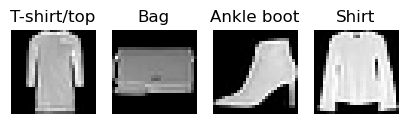

In [22]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(5, 8))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = images[i].squeeze().numpy() 
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [22]:
def make_positional_embedding(time_steps, dimension:int):
    # embedding=torch.zeros(dimension)
    
    # for i in range(dimension):
    #     k=i - i%2
    #     if i%2==0:
    #         embedding[i]=torch.sin(time_step/(10000**(k/dimension)))
    #     else:
    #         embedding[i]=torch.cos(time_step/(10000**(k/dimension)))

    # return embedding
    # idx=torch.arange(dimension)
    # k=idx -(idx%2)
    # angle=time_step/(10000**(k/dimension))
    # embedding[0::2]=torch.sin(angle[0::2])
    # embedding[1::2]=torch.cos(angle[1::2])

    # return embedding
    half = dimension // 2

    freqs_w = torch.exp(
        -torch.log(torch.tensor(10000.0)) * (torch.arange(half, dtype=torch.float32) / half)
    ).to(time_steps.device)
    args = time_steps.float().unsqueeze(1) * freqs_w.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dimension % 2 == 1:
        emb = torch.cat([emb, torch.zeros(time_steps.shape[0], 1, device=time_steps.device)], dim=-1)

    return emb

In [23]:
a=torch.tensor([1,2,3])
a

tensor([1, 2, 3])

In [29]:
make_positional_embedding(a,128).shape

torch.Size([3, 128])

In [25]:
torch.zeros(5)

tensor([0., 0., 0., 0., 0.])

In [30]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim)
        )
    def forward(self, x):  # x: [B, in_dim]
        return self.net(x) 

In [36]:
class UNet(nn.Module):
    def __init__(self,dimension=128, in_channels=1,out_channels=1): # can be 64 too, rule of thumb 2*base_channels(32 here)
        super().__init__()
        
        self.dimension=dimension

        self.act=nn.SiLU(inplace=True)
        # self.pool=nn.MaxPool2d(2)

        self.mlp1=MLP(in_dim=dimension,out_dim=32)
        self.enc1 = nn.Conv2d(in_channels, 32, 3, padding=1)
            
        self.pool1 = nn.MaxPool2d(2) # 14 x 14

        self.mlp2=MLP(in_dim=dimension,out_dim=64)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
            
        self.pool2 = nn.MaxPool2d(2) # 7 x 7

        self.mlp3=MLP(in_dim=dimension,out_dim=128)
        self.enc3 = nn.Conv2d(64, 128, 3, padding=1)
            
        self.pool3 = nn.MaxPool2d(2) # 3 x 3

        self.mlp4=MLP(in_dim=dimension,out_dim=256)
        self.enc4 = nn.Conv2d(128, 256, 3, padding=1)
            
        self.pool4 = nn.MaxPool2d(2) # 1 x 1

        self.mlp5=MLP(in_dim=dimension,out_dim=512)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            # nn.SiLU(inplace=True)
        )  # 1 x 1

        self.mlp6=MLP(in_dim=dimension,out_dim=256)
        self.up4=nn.ConvTranspose2d(in_channels=512,out_channels=256, kernel_size=3, stride=3) # 3 x 3
        self.dec4 = nn.Conv2d(512, 256, 3, padding=1)
            

        self.mlp7=MLP(in_dim=dimension,out_dim=128)
        self.up3=nn.ConvTranspose2d(in_channels=256,out_channels=128, kernel_size=3, stride=2) # 7 x 7
        self.dec3 = nn.Conv2d(256, 128, 3, padding=1)
            

        self.mlp8=MLP(in_dim=dimension,out_dim=64)
        self.up2=nn.ConvTranspose2d(in_channels=128,out_channels=64, kernel_size=2, stride=2) # 14 x 14
        self.dec2 = nn.Conv2d(128, 64, 3, padding=1)
            

        self.mlp9=MLP(in_dim=dimension,out_dim=32)
        self.up1=nn.ConvTranspose2d(in_channels=64,out_channels=32, kernel_size=2, stride=2) # 28 x 28
        self.dec1 = nn.Conv2d(64, out_channels, 3, padding=1)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self,x,time_steps): 
        # x: [B, in_ch, H, W], time_steps: [B] 
        B = x.shape[0]
        uemb = make_positional_embedding(time_steps, self.dimension).to(x.device)

        # Encoder (conv -> add pos -> act)
        h1 = self.enc1(x)
        t1 = self.mlp1(uemb).view(B, 32, 1, 1)
        a1 = self.act(h1 + t1)
        p1 = self.pool1(a1)

        h2 = self.enc2(p1)
        t2 = self.mlp2(uemb).view(B, 64, 1, 1)
        a2 = self.act(h2 + t2)
        p2 = self.pool2(a2)

        h3 = self.enc3(p2)
        t3 = self.mlp3(uemb).view(B, 128, 1, 1)
        a3 = self.act(h3 + t3)
        p3 = self.pool3(a3)

        h4 = self.enc4(p3)
        t4 = self.mlp4(uemb).view(B, 256, 1, 1)
        a4 = self.act(h4 + t4)
        p4 = self.pool4(a4)

        # Bottleneck
        b = self.bottleneck(p4)
        t5 = self.mlp5(uemb).view(B, 512, 1, 1)
        a5 = self.act(b + t5)

        # Decoder: skip connect -> conv -> add pos -> activation 
        u6 = self.up4(a5)                 # (B,256,3,3)
        x6 = torch.cat([u6, a4], dim=1)   # (B,512,3,3)
        d6 = self.dec4(x6)          
        t6 = self.mlp6(uemb).view(B, 256, 1, 1)
        a6 = self.act(d6 + t6)

        u7 = self.up3(a6)
        x7 = torch.cat([u7, a3], dim=1)
        d7 = self.dec3(x7)
        t7 = self.mlp7(uemb).view(B, 128, 1, 1)
        a7 = self.act(d7 + t7)

        u8 = self.up2(a7)
        x8 = torch.cat([u8, a2], dim=1)
        d8 = self.dec2(x8)
        t8 = self.mlp8(uemb).view(B, 64, 1, 1)
        a8 = self.act(d8 + t8)

        u9 = self.up1(a8)
        x9 = torch.cat([u9, a1], dim=1)
        d9 = self.dec1(x9)
        t9 = self.mlp9(uemb).view(B, 32, 1, 1)
        a9 = self.act(d9 + t9)

        out = self.final_conv(a9)
        return out


In [37]:
model = UNet(
    dimension=128,
    in_channels=1,
    out_channels=1
)

# model = model.cuda()  # optional


# --- Create fake input batch ---
B = 4
x = torch.randn(B, 1, 28, 28)   # input
t = torch.randint(0, 1000, (B,))  # timesteps

print("Input shape:", x.shape)
print("Timestep shape:", t.shape)

# --- Run forward pass ---
out = model(x, t)

print("Output shape:", out.shape)

Input shape: torch.Size([4, 1, 28, 28])
Timestep shape: torch.Size([4])
Output shape: torch.Size([4, 1, 28, 28])
